# Exploring: Variation of Information

## Background

My projects involve trying to compare the outputs of different climate models. There are currently more than 20+ climate models from different companies and each of them try to produce the most accurate prediction of some physical phenomena, e.g. Sea Surface Temperature, Mean Sea Level Pressure, etc. However, it's a difficult task to provide accurate comparison techniques for each of the models. There exist some methods such as the mean and standard deviation. There is also a very common framework of visually summarizing this information in the form of Taylor Diagrams. However, the drawback of using these methods is that they are typically non-linear methods and they cannot handle multidimensional, multivariate data. 

Another way to measure similarity would be in the family of Information Theory Measures (ITMs). Instead of directly measuring first-order output statistics, these methods summarize the information via a probability distribution function (PDF) of the dataset. These can measure non-linear relationships and are naturally multivariate that offers solutions to the shortcomings of the standard methods. I would like to explore this and see if this is a useful way of summarizing information.

This is removing the 

## Code

In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as smi

import sys
sys.path.insert(0, '/home/emmanuel/code/kernel_model_zoo/')


import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from kernellib.dependence import HSIC

In [15]:
SAVE_PATH = "/home/emmanuel/projects/2020_rbig_rs/reports/figures/explore/vi/"

## Data

We will use the classic dataset for Anscombe's quartet. This is a staple dataset which shows how we need to take care when comparing two datasets. In the example, we will show how visually, two datasets will look similar, but using a correlation measure like the Pearson's coefficient will fail because it is not able to capture the non-linear relationship between the two distributions.

In [418]:
# load dataset
df_anscombe = sns.load_dataset('anscombe')

In [419]:
df_anscombe.dataset.unique()

array(['I', 'II', 'III', 'IV'], dtype=object)

In [420]:
def get_case(df: pd.DataFrame, case: str='I'):
    return df[df['dataset'] == case]

In [423]:
def plot_cases(df: pd.DataFrame, case: str='I', save=True, plot_type='reg'):
    
    df = get_case(df, case)
    
    plt.figure(figsize=(4,4))
    if plot_type == 'reg':
        pts = sns.regplot(
            x="x", 
            y="y", 
            data=df, 
        )
    elif plot_type == 'joint':
        pts = sns.jointplot(
            x="x", 
            y="y", 
            data=df, 
            kind="regplot",
        )
    elif plot_type == 'density':
        pts = sns.jointplot(
            x="x", 
            y="y", 
            data=df, 
            kind="kde",
        )
    else:
        raise ValueError('')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.tight_layout()
    if save is not None:
        plt.savefig(SAVE_PATH + f'demo_case{case}_{plot_type}.png', dpi=200, transparent=True)
    return None


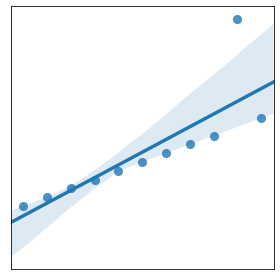

In [431]:
plot_cases(df_anscombe, 'III', plot_type='reg')

This is a very simple case where we have a linear relationship between the datasets. The regression plot above shows a linear line that is fit between the two distributions. We can also see the marginal distributions (the histograms) for X and Y. As you can see, they are definitely similar. But now, we are going to look at a way to summarize this information.

## Mathematics

There are a few important quantities to consider when we need to represent the statistics and compare two datasets. 

* Variance
* Covariance
* Correlation
* Root Mean Squared

### Covariance

The covariance is a measure to determine how much two variances change. The covariance between X and Y is given by:

$$C(X,Y)=\frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_i)$$

where $N$ is the number of elements in both datasets. Notice how this formula assumes that the number of samples for X and Y are equivalent. This measure is unbounded as it can have a value between $-\infty$ and $\infty$. Let's look at an example of how to calculate this below.

In [21]:
# covariance formula
def cov(X, Y):
    
    n_samples = X.shape[0]
    
    # get mean
    X_mu = X.mean()
    Y_mu = Y.mean()
        
    cov_xy = 0

    # loop through the data points
    for ix in range(n_samples):
        cov_xy += (X.values[ix] - X_mu) * (Y.values[ix] - Y_mu)
        
    
    return cov_xy / n_samples

In [22]:
# extract the data
X = get_case(df_anscombe, 'I')['x']
Y = get_case(df_anscombe, 'I')['y']

# get covariance
cov_xy = cov(X,Y)

print(cov_xy)

5.000909090909091


In [23]:
X.values[:, None].reshape(-1, 1).shape

(11, 1)

That number is fairly meaningless now. But we can compare the covariance number of this versus the other cases.

#### Refactor

We can remove the loop by doing a matrix multiplication.

$$C(X,Y)=\frac{1}{N} (X-X_\mu)^\top (Y-Y_\mu)$$

where $X,Y \in \mathbb{R}^{N\times 1}$

In [24]:
np.dot(X[:, None].T-X.mean(), Y[:, None]-Y.mean())/X.shape[0]

# covariance formula
def cov(X, Y):
    
    n_samples = X.shape[0]
    
    # get mean
    X_mu = X.mean()
    Y_mu = Y.mean()
        
    # remove mean from data
    X -= X_mu
    Y -= Y_mu
    
    # Ensure 2d
    X = np.atleast_2d(X).reshape(-1, 1)
    Y = np.atleast_2d(Y).reshape(-1, 1)

    # calculate the covariance
    cov_xy = X.T @ Y    
    return (cov_xy / n_samples).item()

In [25]:
def test_anscombe(func, save_name=None):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,5))

    for iax, icase in zip(axs.ravel(), ['I', 'II', 'III', 'IV']):

        # data
        X = get_case(df_anscombe, icase)['x']
        Y = get_case(df_anscombe, icase)['y']

        output = func(X.values,Y.values)

        iax.scatter(X.values, Y.values, label=f"Case {icase}: $C$={output:.2f}")
        iax.legend()
    #     iax.legend(f"Case: {icase}")
        # get covariance


    #     print(f"Case {icase}: {cov_xy.item()}")
    plt.tight_layout()
    
    if save_name is not None:
        plt.savefig(SAVE_PATH + f"demo_{save_name}.png")
        
    plt.show()

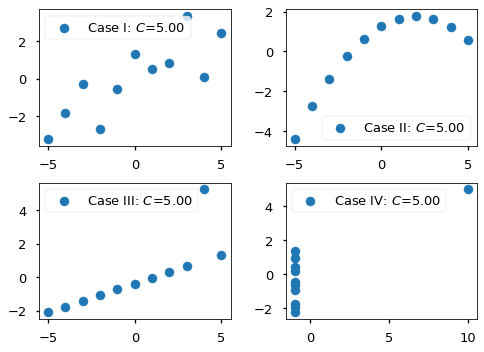

In [26]:
test_anscombe(cov, 'cov')

#### Multi-Variate (Multi-Dimensional)

In [408]:
np.random.seed(123)

X = np.random.randn(20, 2)
Y = 0.5 * X

# calculate covariance matrix
cov = np.cov(X.squeeze(), Y.squeeze())

print(X.shape, Y.shape, cov.shape)

(20, 2) (20, 2) (40, 40)


In [409]:
cov.shape

(40, 40)

In [410]:
def cov_hs_features(X, Y):
    
    # calculate covariance matrix
    cov_xy = np.cov(X, Y)
    
    # summarize information
    cov_sum = np.linalg.norm(cov, ord='fro')
    
    return cov_sum

In [411]:
# ||X.T @ Y||_F - feature space 
lhs = np.linalg.norm(X.T @ Y, ord='fro')**2
print(lhs)

# ||XX.T @ YY.T||_F - sample space
mhs = np.trace(X @ X.T @ Y @ Y.T)
print(mhs)

379.05326003069405
379.053260030694


In [412]:
# ||X.T @ Y||_F - feature space 
lhs = np.linalg.norm(np.cov(X,Y), ord='fro')**2
print(lhs)

# ||XX.T @ YY.T||_F - sample space
mhs = np.trace(X @ X.T @ Y @ Y.T)
print(mhs)

913.0831824181817
379.053260030694


In [396]:
# RHS
raw = np.trace(X @ Y.T) / np.sqrt(np.trace(X @ X.T) * np.trace(Y @ Y.T))
print(raw)

# MHS


1.0


#### Formula 1

$$\frac{tr(XY^\top}{\sqrt{tr(XX^\top)tr(YY^T)}}$$

In [404]:
# raw formula
raw = np.trace(X @ Y.T) / np.sqrt(np.trace(X @ X.T) * np.trace(Y @ Y.T))

print(raw)

# numerator 
numer1 = np.trace(X @ Y.T)**2
numer2 = np.linalg.norm(X @ Y.T)
print(numer1, numer2)


1.0
229.5889532845504 15.152193018984098


#### Formula II

$$\frac{tr(XX\top YY^\top)}{\sqrt{tr(XX^\top XX^\top)tr(YY^\top YY^\top)}}$$

In [395]:
# formula 2
S = X @ X.T
T = Y @ Y.T

raw  = np.trace(S.T @ T) / np.sqrt(np.trace(S.T @ S) * np.trace(T.T @ T))

print(raw)

# numerator 
numer1 = np.trace(S.T @ T)
numer2 = np.linalg.norm(S.T @ T)
print(numer1, numer2)

# denominator
denom1 = np.sqrt(np.trace(S.T @ S) * np.trace(T.T @ T))
denom2 = np.sqrt(np.linalg.norm(S.T @ S) * np.linalg.norm(T.T @ T))
print(denom1, denom2)

0.9999999999999999
229.5889532845504 229.58895328455043
229.58895328455043 229.58895328455043


#### Proposed

$$\frac{tr(X^\top Y)}{\sqrt{tr(X^\top X)tr(Y^\top Y)}}$$

In [390]:
# proposed
raw = np.trace(X.T @ Y) / np.sqrt(np.trace(X.T @ X) * np.trace(Y.T @ Y))

print(raw)

# numerator 
numer1 = np.trace(X.T @ Y)
numer2 = np.linalg.norm(X.T @ Y)
print(numer1, numer2)

1.0
15.152193018984097 15.152193018984097


In [334]:
cov_feat_norm = cov_hs_features(X, Y)
print(cov_feat_norm)

X_ft_norm = cov_hs_features(X,X)
Y_ft_norm = cov_hs_features(Y,Y)

corr_feat_norm = cov_feat_norm / (X_ft_norm * Y_ft_norm)
print(corr_feat_norm)

1.1016198535241324
0.9077541556653632


In [352]:
np.inner(np.cov(X,X.T), np.cov(Y,Y.T))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 20

In [328]:
def cov_hs_samples(X, Y):
    
    # calculate samples covariance matrix
    K_x = np.cov(X.T)
    K_y = np.cov(Y.T)
    
    # summarize
    return np.sum(K_x * K_y)

In [336]:
cov_samp_norm = cov_hs_samples(X, Y)
print(cov_samp_norm)

X_samp_norm = cov_hs_samples(X,X)
Y_samp_norm = cov_hs_samples(Y,Y)

corr_samp_norm = cov_samp_norm / np.sqrt(X_samp_norm * Y_samp_norm)
print(corr_samp_norm)

0.0014930782114528126
1.0


In [330]:
cov_norm = cov_hs_features(X, Y)
print(cov_norm)

1.1016198535241324


In [279]:
def get_linear_hsic(X, Y):
    
    hsic_model = HSIC(kernel='linear', scorer='hsic', bias=True)

    hsic_model.fit(X,Y);

    hsic_score = hsic_model.score(X)
    
    return hsic_score

In [338]:
def get_linear_cka(X, Y):
    
    hsic_model = HSIC(kernel='linear', scorer='tka')

    hsic_model.fit(X,Y);

    hsic_score = hsic_model.score(X)
    
    return hsic_score

In [339]:
cka_score = get_linear_cka(X, Y)
print(cka_score)

1.0000000000000002


In [281]:
hsic_score = get_linear_hsic(X, Y)
print(hsic_score)

0.0060638424362907456


In [286]:
# Samples Covariance Trace
np.trace(np.cov(X.T) @ np.cov(Y.T))

0.00671893898757977

In [288]:
# Feature Covariance Trace
np.linalg.norm(np.cov(X,Y), ord='fro')

0.20492283589774365

In [271]:
np.linalg.norm(X.T @ Y, ord='fro')

13.366924136623567

In [269]:
def corr_hs(X, Y):
    
    # calculate summarize covariance matrix
    cov_sum = cov_hs(X, Y)
    
    # summarize 
    X_sum = cov_hs(X, X)
    Y_sum = cov_hs(Y, Y)
    
    # calculate correlation
    return cov_sum / np.sqrt(X_sum * Y_sum)

In [270]:
corr_sum = corr_hs(X,Y)
print(corr_sum)

1.0


In [235]:
# calculate empirical covariance
cov = X.T @ Y
assert cov.shape == (X.shape[1], Y.shape[1])

cov

array([[2.55059567, 2.2232904 , 1.81886892, 2.1282874 , 2.6284517 ],
       [2.2232904 , 3.78740257, 2.82952369, 2.78454246, 2.93383308],
       [1.81886892, 2.82952369, 2.83388253, 2.62597812, 2.54855784],
       [2.1282874 , 2.78454246, 2.62597812, 2.92247425, 2.66389554],
       [2.6284517 , 2.93383308, 2.54855784, 2.66389554, 3.48777985]])

So, we see that the covariance doesn't seem to change very much between datasets. 

### Correlation

This is the normalized version of the covariance measured mentioned above. This is done by dividing the covariance by the product of the standard deviation of the two samples X and Y. So the forumaltion is:

$$\rho(X, Y) = \frac{C(X,Y)}{\sigma_x \sigma_y}$$

With this normalization, we now have a measure that is bounded between -1 and 1. This makes it much more interpretable and also invariant to isotropic scaling, $\rho(X,Y)=\rho(\alpha X, \beta Y)$ where $\alpha, \beta \in \mathbb{R}^{+}$

In [27]:
def corr(X, Y):
    
    # get standard deviation
    X_std, Y_std = X.std(), Y.std()
    
    # calculate the correlation
    cov_xy = cov(X, Y)
    
    # calculate the correlation
    return (cov_xy / (X_std * Y_std)).item()

In [28]:
corr_xy = corr(X, Y)

print(corr_xy)

0.7422004694043999


Now that it is bounded between -1 and 1, this value let's us know that this value is equivalent to being close to 1. So fairly similar.

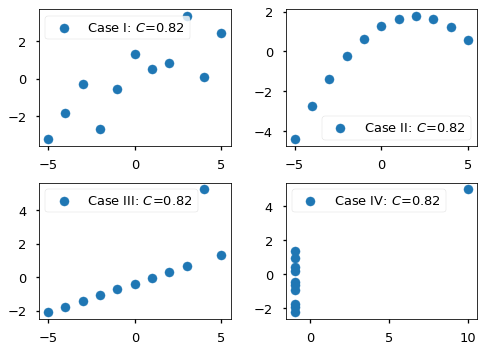

In [29]:
test_anscombe(corr, 'corr')

So at this point, this is a bit of a red flag. All of the $\rho$ values are the same but we can see very clearly that there are some key differences between the distributions. The covariance nor the correlation measure gave us useful information.

### Root Mean Squared

This is a popular measure for measuring the errors between two datasets. More or less, it is a covariance measure that penalizes higher deviations between the datasets.

In [30]:
# covariance formula
def rmse(X, Y):
    
    n_samples = X.shape[0]
    
    # get mean
    X_mu = X.mean()
    Y_mu = Y.mean()
        
    # remove mean from data
    X -= X_mu
    Y -= Y_mu

    # calculate the squared covariance
    cov_xy = np.average((X - Y) ** 2, axis=0)   
    
    return np.sqrt((cov_xy))

In [31]:
rmse_xy = rmse(X, Y)

print(rmse_xy)

1.936554834777258


#### Refactor

The scikit-learn library has a built-in `mean_sqared_error` function which you can call and then use the `np.sqrt` on the output.

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
def rmse(X, Y):
    # calculate the squared covariance
    rmse_xy = mean_squared_error(X, Y)  
    
    return np.sqrt(rmse_xy)

In [34]:
rmse_xy = rmse(X,Y)
print(rmse_xy)

1.936554834777258


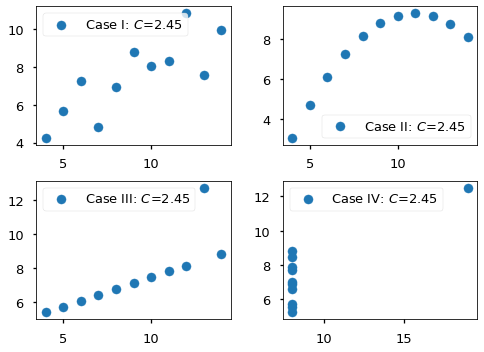

In [35]:
test_anscombe(rmse, 'rmse')

### HSIC

In [60]:
def get_linear_hsic(X, Y):
    
    hsic_model = HSIC(kernel='linear', scorer='hsic', bias=True)

    hsic_model.fit(X[:, None],Y[:, None]);

    hsic_score = hsic_model.score(X[:, None])
    
    return hsic_score

In [61]:
hsic_score = get_linear_hsic(X,Y)

print(hsic_score)

24.972734710743808


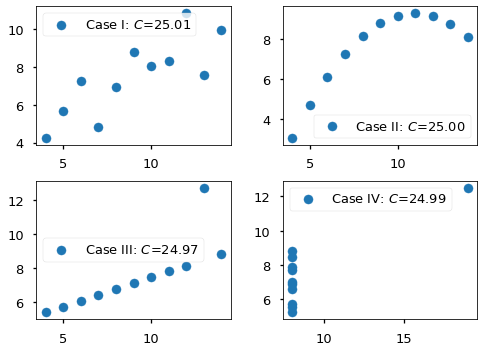

In [62]:
test_anscombe(get_linear_hsic, 'hsic_lin')

#### RBF Kernel

In [55]:
def get_rbf_hsic(X, Y):
    
    hsic_model = HSIC(kernel='rbf', scorer='hsic')

    hsic_model.fit(X[:, None],Y[:, None]);

    hsic_score = hsic_model.score(X[:, None])
    
    return hsic_score

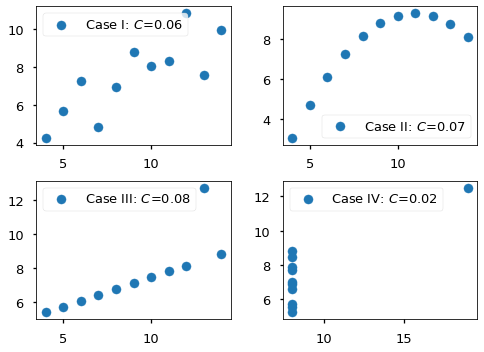

In [56]:
test_anscombe(get_rbf_hsic, 'hsic_rbf')

### Kernel Alignment

#### Linear

In [64]:
def get_linear_ka(X, Y):
    
    hsic_model = HSIC(kernel='linear', scorer='tka')

    hsic_model.fit(X[:, None],Y[:, None]);

    hsic_score = hsic_model.score(X[:, None])
    
    return hsic_score

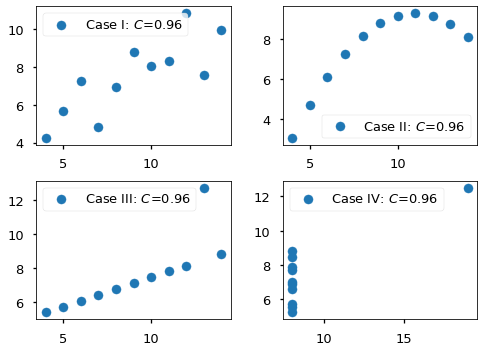

In [65]:
test_anscombe(get_linear_ka, 'cka_lin')

#### RBF Kernel

In [66]:
def get_rbf_ka(X, Y):
    
    hsic_model = HSIC(kernel='rbf', scorer='tka')

    hsic_model.fit(X[:, None],Y[:, None]);

    hsic_score = hsic_model.score(X[:, None])
    
    return hsic_score

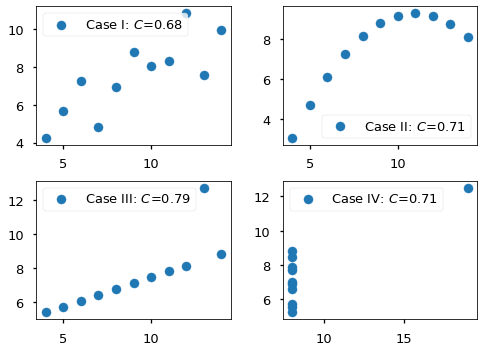

In [67]:
test_anscombe(get_rbf_ka, 'ka_rbf')

## Mutual Information

In this section, I will be doing the same thing as before except this time I will use the equivalent Information Theory Measures. In principle, they should be better at capturing non-linear relationships and I will be able to add different representations using spatial-temporal information.

### Entropy

This is the simplest and it is analogous to the standard deviation $\sigma$. Entropy is defined by

$$H(X) = - \int_{X} f(x) \log f(x) dx$$

This is the expected amount of uncertainty present in a given distributin function $f(X)$. It captures the amount of surprise within a distribution. So if there are a large number of low probability events, then the expected uncertainty will be higher. Whereas distributions with fairly equally likely events will have low entropy values as there are not many surprise events, e.g. Uniform.

1.9670005831544313


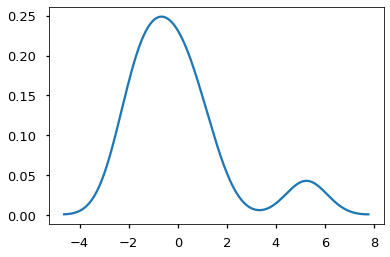

In [101]:
kde = smi.nonparametric.KDEUnivariate(Y)
kde.fit()
print(kde.entropy)
plt.plot(kde.support, kde.density)

In [194]:
import scipy.stats

def entropy(data, method='counts'):
    

    if method == 'counts':
        _, pdata = np.unique(data, return_counts=True)
        entropy = scipy.stats.entropy(pdata)
    elif method == 'kde':
        kde = smi.nonparametric.KDEUnivariate(data)
        kde.fit()
        entropy = kde.entropy
    else:
        raise ValueError('Unrecognized method.')
    return entropy

In [195]:
Hx = entropy(X, 'counts')
Hy = entropy(Y, 'counts')

print(Hx, Hy)

2.3978952727983707 2.3978952727983707


### Mutual Information

Given two distributions X and Y, we can calculate the mutual information as

$$I(X,Y) = \int_X\int_Y p(x,y) \log \frac{p(x,y)}{p_x(x)p_y(y)}dxdy$$

where $p(x,y)$ is the joint probability and $p_x(x), p_y(y)$ are the marginal probabilities of $X$ and $Y$ respectively. We can also express the mutual information as a function of the Entropy $H(X)$

$$I(X,Y)=H(X) + H(Y) - H(X,Y)$$

In [200]:
def mutual_info(X,Y, method='kde'):
    
    Hx = entropy(X, method)
    Hy = entropy(Y, method)
    Hxy = entropy(np.concatenate((X,Y)), method)
    return Hx + Hy - Hxy

In [201]:
Hxy = entropy(pd.concat((X,Y)))

mi_xy = mutual_info(X.values, Y.values)

print(mi_xy)

2.203120400100416


/home/emmanuel/.conda/envs/it4dnn/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/emmanuel/.conda/envs/it4dnn/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/emmanuel/.conda/envs/it4dnn/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in multiply
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/emmanuel/.conda/envs/it4dnn/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:232: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -integrate.quad(entr, a, b, args=(endog,))[0]


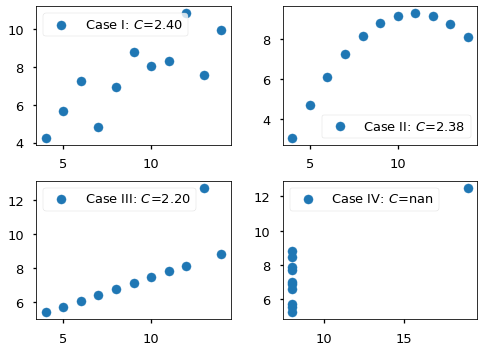

In [202]:
test_anscombe(mutual_info, 'kde')

In [215]:
def norm_mutual_info(X,Y, method='kde'):
    
    Hx = entropy(X, method)
    Hy = entropy(Y, method)
    Hxy = entropy(np.concatenate((X,Y)), method)
    
    # mutual information
    mi_xy =  Hx + Hy - Hxy
    return (mi_xy / (np.sqrt(Hx * Hy)))

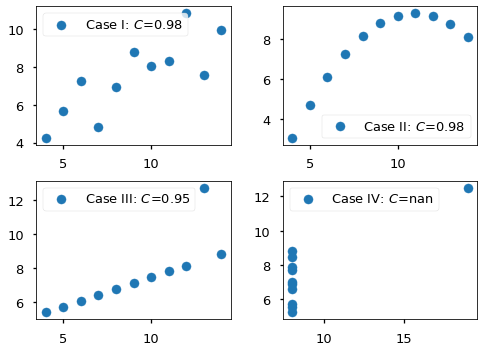

In [216]:
test_anscombe(norm_mutual_info, 'nkde')

In [221]:
def red_mutual_info(X,Y, method='kde'):
    
    Hx = entropy(X, method)
    Hy = entropy(Y, method)
    Hxy = entropy(np.concatenate((X,Y)), method)
    
    # mutual information
    mi_xy =  Hx + Hy - Hxy
    return (2 * mi_xy / (Hx + Hy))

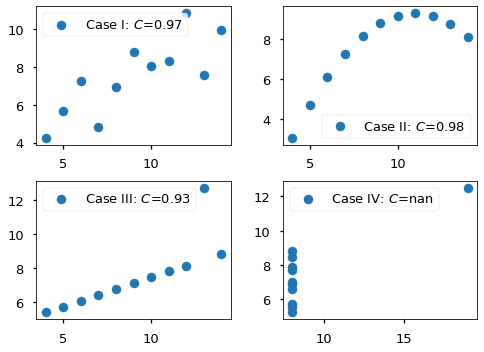

In [222]:
test_anscombe(red_mutual_info, 'rkde')

### Variation of Information

$$
\begin{aligned}
VI(X,Y) &= H(X) + H(Y) - 2I(X,Y) \\
&= I(X,X) + I(Y,Y) - 2I(X,Y)
\end{aligned}$$

In [223]:
def variation_info(X,Y, method='kde'):
    
    Hx = entropy(X, method)
    Hy = entropy(Y, method)
    Hxy = entropy(np.concatenate((X,Y)), method)
    
    # mutual information
    mi_xy =  Hx + Hy - Hxy
    
    # variation of information
    vi_xy = Hx + Hy - 2 * mi_xy
    return vi_xy

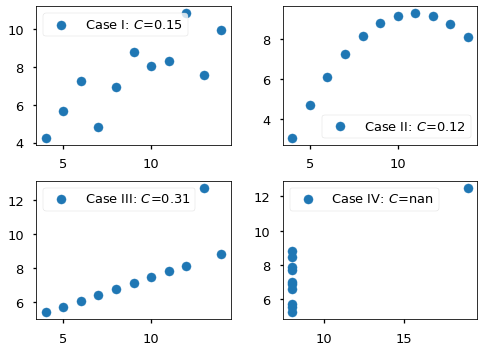

In [224]:
test_anscombe(variation_info, 'vikde')

### RVI-Based Diagram

Analagous to the Taylor Diagram, we can summarize the ITMs in a way that was easy to interpret. It used the relationship between the entropy, the mutual information and the normalized mutual information via the triangle inequality. Assuming we can draw a diagram using the law of cosines;

$$c^2 = a^2 + b^2 - 2ab \cos \phi$$




we can write this in terms of $\sigma$, $\rho$ and $RMSE$ as we have expressed above.

$$\begin{aligned}
\text{RVI}^2 &= H(X) + H(Y) - 2 \sqrt{H(X)H(Y)} \frac{I(X,Y)}{\sqrt{H(X)H(Y)}} \\
&= H(X) + H(Y) - 2 \sqrt{H(X)H(Y)} \rho
\end{aligned}$$

where The sides are as follows:

* $a = \sigma_{\text{obs}}$ - the entropy of the observed data
* $b = \sigma_{\text{sim}}$ - the entropy of the simulated data
* $\rho = \frac{I(X,Y)}{\sqrt{H(X)H(Y)}}$ - the normalized mutual information
* $RMSE$ - the variation of information between the two datasets

In [203]:
h_a = entropy(X, 'counts')
h_b = entropy(Y, 'kde')
print('H(X),H(Y):',h_a, h_b)

# joint entropy
h_ab = entropy(pd.concat((X,Y)), 'kde')
print('H(X,Y):',h_ab)

# mutual information
mi_ab = h_a + h_b - h_ab
print('MI(X,Y):', mi_ab)

# normalized mutual information
nmi_ab = mi_ab / np.sqrt(h_a * h_b)
print('NMI(X,Y):', nmi_ab)

# scaled mutual info
smi_ab = mi_ab * (h_ab / (h_a * h_b))
print('SMI(X,Y):', smi_ab)

# cos rho term
c_ab = 2 * smi_ab - 1
print('C_XY:', c_ab)

# vi
vi = h_a + h_b  - 2 * np.sqrt(h_a * h_b) * nmi_ab

print('VI(X,Y):',vi)

H(X),H(Y): 2.3978952727983707 1.967000583154429
H(X,Y): 2.51573500302577
MI(X,Y): 1.8491608529270298
NMI(X,Y): 0.8514464531077769
SMI(X,Y): 0.986290574938243
C_XY: 0.972581149876486
VI(X,Y): 0.6665741500987403


In [204]:
def vi_coeffs(X, Y, method='counts'):
    
    # entropy observations
    h_a = entropy(X, method)
    
    # entropy simulated
    h_b = entropy(Y, method)
    
    # joint entropy
    h_ab = entropy(pd.concat((X,Y)), method)    
    
    # mutual information
    mi_ab = h_a + h_b - h_ab
    
    # normalized mutual information
    nmi_ab = mi_ab / np.sqrt(h_a * h_b)
    
    # scaled mutual information
    smi_ab = 2 * mi_ab * (h_ab / (h_a * h_b)) - 1
    
    # vi
    vi_ab = h_a + h_b  - 2 * np.sqrt((h_a * h_b)) * nmi_ab
        
    # save coefficients
    data = {
        'h_a': h_a,
        'h_b': h_b,
        'nmi': nmi_ab,
        'smi': smi_ab,
        'theta': np.arccos(nmi_ab),
        'vi': vi_ab
    }
    return data

In [205]:
# Model I
X = get_case(df_anscombe, 'I')['x']
Y = get_case(df_anscombe, 'I')['y']
data1 = vi_coeffs(X, Y, 'kde')
print(data1)

# Model II
X = get_case(df_anscombe, 'II')['x']
Y = get_case(df_anscombe, 'II')['y']
data2 = vi_coeffs(X, Y, 'kde')
print(data2)

# Model III
X = get_case(df_anscombe, 'III')['x']
Y = get_case(df_anscombe, 'III')['y']
data3 = vi_coeffs(X, Y, 'kde')
print(data3)

# # Model IV
# X = get_case(df_anscombe, 'IV')['x']
# Y = get_case(df_anscombe, 'IV')['y']
# data4 = vi_coeffs(X, Y)
# print(data4)

{'h_a': 2.7518548199717574, 'h_b': 2.2080793522856723, 'nmi': 0.9751276249886281, 'smi': 1.0224173292681424, 'theta': 0.2235002023733858, 'vi': 0.15251984951237407}
{'h_a': 2.7518548199717574, 'h_b': 2.1269598407974937, 'nmi': 0.9842327930994981, 'smi': 1.0321990011233386, 'theta': 0.1778134760779669, 'vi': 0.11647649545914085}
{'h_a': 2.7518548199717574, 'h_b': 1.967000583154429, 'nmi': 0.9469416711631927, 'smi': 1.0478734393463243, 'theta': 0.32721332665482533, 'vi': 0.31261460292535403}


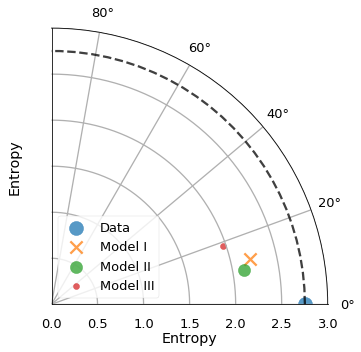

In [206]:
import matplotlib.pyplot as plt
import numpy as np

theta = np.linspace(0,np.pi)
r = np.sin(theta)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, polar=True)
m = ax.scatter(0, data1['h_a'], s=200, alpha=0.75, label='Data', zorder=0)
m1 = ax.scatter(data1['theta'], data1['h_b'], s=150, alpha=0.75, marker='x', label='Model I')
m1 = ax.scatter(data2['theta'], data2['h_b'], s=150, alpha=0.75, marker='o', label='Model II')
m1 = ax.scatter(data3['theta'], data3['h_b'], s=150, alpha=0.75, marker='.', label='Model III')
# m1 = ax.scatter(theta4, b4, s=100, alpha=0.75, marker='o', label='Model II')
# ax.plot(0)
ax.set_ylim([0, 3])
# ax.set_xticks([0.1, 0.2, 0.3, 0.9])
# ax.set_xticklabels([1.0, 0.9, 0.8, 0.6, 0.3, 0.2, 0.1])
# m1 = ax.scatter(theta1, a, s=50, alpha=0.75)
# m1 = ax.scatter(theta1, a, s=50, alpha=0.75)
c = ax.plot(theta, data1['h_a'] * np.ones(theta.shape), color='black', linestyle='dashed', alpha=0.75)
ax.set_xlabel('Entropy', labelpad=20)
ax.set_ylabel('Entropy', labelpad=20)
plt.legend()
ax.set_thetamin(0)
ax.set_thetamax(90)
plt.tight_layout()
plt.savefig(SAVE_PATH + 'demo_vi.png')
plt.show()